In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Kalman Filter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r'data/finance.csv',index_col=0,low_memory=False)

In [3]:
df.index=pd.to_datetime(df.index)

In [4]:
test_date = pd.datetime(2017,1,1)

In [227]:
df['ret']=np.concatenate([[0],df['close'].iloc[1:].values/df['close'].iloc[:-1].values-1],axis=0)

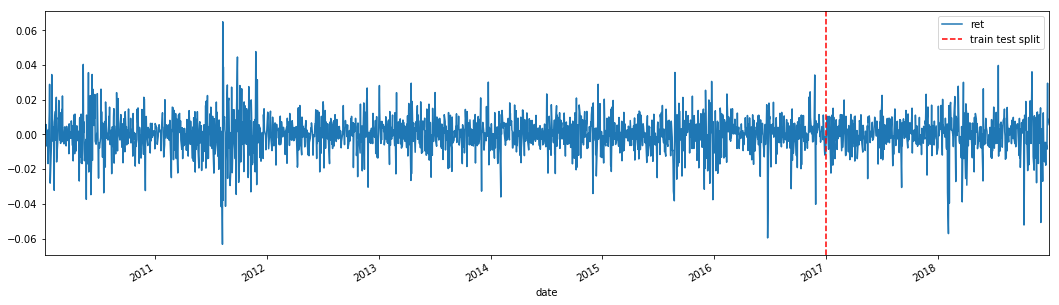

In [228]:
df['ret'].plot(figsize=(18,5))
plt.axvline(test_date,ls='--',color='r',label='train test split')
plt.legend()

Text(0.5, 1.0, 'Financial Industry Close Price')

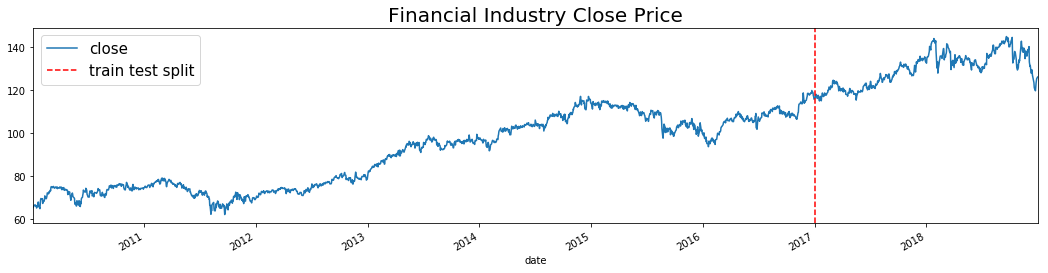

In [5]:
df['close'].plot(figsize=(18,4))
plt.axvline(test_date,ls='--',color='r',label='train test split')
# plt.fill_between(df.index,y1=plt.ylim()[0],y2=plt.ylim()[1],where=np.logical_and(df.index>=pd.datetime(2012,1,1), df.index<=pd.datetime(2014,11,1) ),alpha=0.2,color='green',label='bull')
# plt.fill_between(df.index,y1=plt.ylim()[0],y2=plt.ylim()[1],where=np.logical_and(df.index>=pd.datetime(2015,3,1), df.index<=pd.datetime(2016,11,1) ),alpha=0.2,color='red',label='bear')
plt.legend(fontsize=15)
# plt.text(x=pd.datetime(2012,3,1),y=120,s='monthly mean ret: 2.02%\nmonthly std: 0.047',fontsize=13)
# plt.text(x=pd.datetime(2015,3,1),y=120,s='monthly mean ret: -0.26%\nmonthly std: 0.057',fontsize=13)
plt.title('Financial Industry Close Price',fontsize=20)
# plt.title('Financial Industry Price | Bull and Bear',fontsize=20)

In [6]:
df['ret']=np.concatenate([[0],df['close'].values[1:]/df['close'].values[:-1]],axis=0)

In [48]:
df[np.logical_and(df.index>=pd.datetime(2015,3,1), df.index<=pd.datetime(2016,6,1) )].mean()

close    105.901529
low      105.212968
high     106.547439
open     105.920707
ret        0.999848
dtype: float64

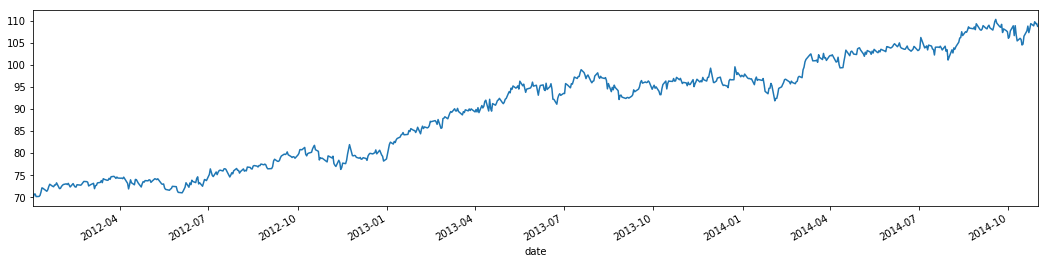

In [18]:
df['close'].plot()

In [10]:
train = df[df.index<test_date]
train_val_split=int(0.2*len(train))
train_set,val_set = train.iloc[:-train_val_split],train.iloc[-train_val_split:]
test = df[df.index>=test_date]

## Identify Transition Equation 

### ARiMA for hyperparameter

#### Step 1: Testing and Ensuring Stationarity

Augmented Dickey-Fuller unit root test.


In [229]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(res,show_plot=True):
    result = adfuller(res)
    if show_plot:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    return result[0]

In [230]:
_=test_stationary(train_set['close'])

ADF Statistic: -0.472058
p-value: 0.897355
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#### Step 2: Identification of p and q

Autocorrelation function (ACF) and Partial Autocorrelation function (PACF). PACF will be used to identify the order (p) of the AR model.  ACF plot will be used to identify the order of the MA process. If we have one significant spike at lag 1 on the ACF

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

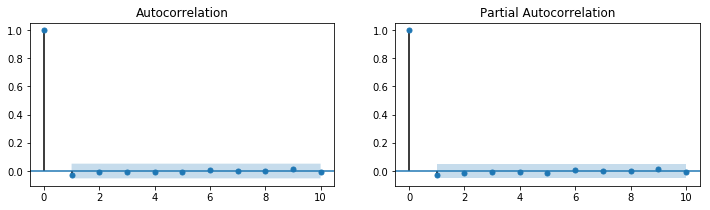

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plot_acf(train_set['ret'],ax=plt.gca(),alpha=.05, lags=10)
plt.subplot(1,2,2)
plot_pacf(train_set['ret'],ax=plt.gca(),alpha=.05, lags=10)
plt.show()

MA(1) and AR(1) is better to model this return process.

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
model = ARIMA(train_set['ret'], order=(1,1,1)).fit(disp=0)

/usr/share/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/share/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/share/miniconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.ret   No. Observations:                 1409
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3001.215
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 13 May 2019   AIC                          -5994.430
Time:                        17:30:13   BIC                          -5973.428
Sample:                             1   HQIC                         -5986.582
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.941e-06   1.88e-06      1.564      0.118   -7.44e-07    6.63e-06
ar.L1.D.ret    -0.0045      0.072     -0.063      0.950      -0.145       0.136
ma.L1.D.ret    -1.0000      0.003   -339.617      0.000      -1.006      -0.994
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -220.2174           +0.0000j          220.2174            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## Model return
### Normal distribution: Kalman filter + ARIMA

\begin{align}
\left\{
 \begin{array}{ll}
     \Phi(L)(p_{t}) = \theta(L)\epsilon_t & \epsilon_t \sim N(0,\sigma^2_\epsilon), \text{L is lag operator}\\
     y_t = \theta_t + \delta_t & \delta_t \sim N(0,\sigma^2_\delta)\\
 \end{array}
\right.\Rightarrow
\left\{
 \begin{array}{l}
     p_{t|t-1} = \sum_{i=1}^5\Phi_ip_{t-i|t-i}\\
     \sigma^2_{t|t-1} = \sum_{i=1}^5\Phi_i\sigma_{t-i|t-i} + \sigma^2_\epsilon\sum_{i=1}^5\theta_i\\
     \theta_{t|t} = p_{t-1|t-1}+\frac{\sigma^2_{t|t-1}}{\sigma^2_{t|t-1}+\sigma^2_\delta}(y_t-p_{t-1|t-1})\\
     \sigma^2_{t|t} = (\frac{1}{\sigma^2_{t|t-1}}+\frac{1}{\sigma^2_\delta})^{-1}
 \end{array}
\right.
\end{align}


In [241]:
def kalman_filter(y=df,title='Finance',theta0=0,sigma0=0,x=[None],sigma_epsilon=1e-2, sigma_delta=1e-4,model=model,beta=np.ones(4)):
    ar = model.arparams
    ma_sum = sum(model.maparams)
    n=len(ar)
    
    sigma = [sigma0]*n
    theta = [theta0]*n
    if len(x)==1:
        for yt in y:
            theta_1 = sum(ar*theta[-n:])
            sigma_t_1=sum(ar*sigma[-n:])+sigma_epsilon*ma_sum
            theta_t = theta_1+sigma_t_1/(sigma_t_1+sigma_delta)*(yt-theta_1)
#             if np.abs(theta_t)>1:
#                 theta_t=1*np.sign(theta_t)
            theta.append(theta_t)
            sigma.append(1/(1/sigma_t_1+1/sigma_delta))
    else:
        for yt,xt in zip(y,x):
            theta_1 = sum(ar*theta[-n:])+sum(beta*xt)
            sigma_t_1=sum(ar*sigma[-n:])+sigma_epsilon*ma_sum
            theta_t = theta_1+sigma_t_1/(sigma_t_1+sigma_delta)*(yt-theta_1)
#             if np.abs(theta_t)>1:
#                 theta_t=1*np.sign(theta_t)
            theta.append(theta_t)
            sigma.append(1/(1/sigma_t_1+1/sigma_delta))
    
    plt.figure()
    plt.plot_date(df.index[1:],df[1:],'k-',label='noisy daily price')
    plt.plot_date(df.index[1:],theta[1:],'r--',label='a posteri estimate')
    # plt.axhline(x,color='g',label='truth value')
    plt.legend(fontsize=15)
    plt.title('Estimate vs. iteration step | '+title, fontweight='bold',fontsize=20)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('Close price',fontsize=15)
    return np.array(theta[n:]),np.array(sigma[n:])

In [246]:
theta,sigma = kalman_filter1(val_set['close'],theta0=0,sigma0=0,model=model)#val_set[['close','open','high','low']].values,

/usr/share/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [3]:
ind_list = ['Transportation','Finance','Manufactoring','Wholesale','Services','Public','Construction','Retail','Mining']

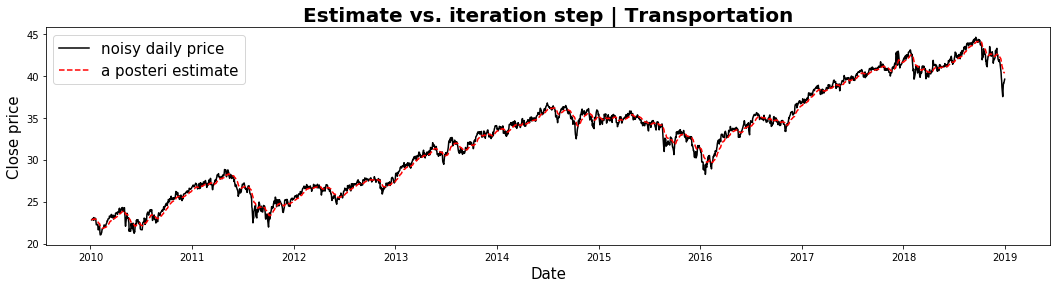

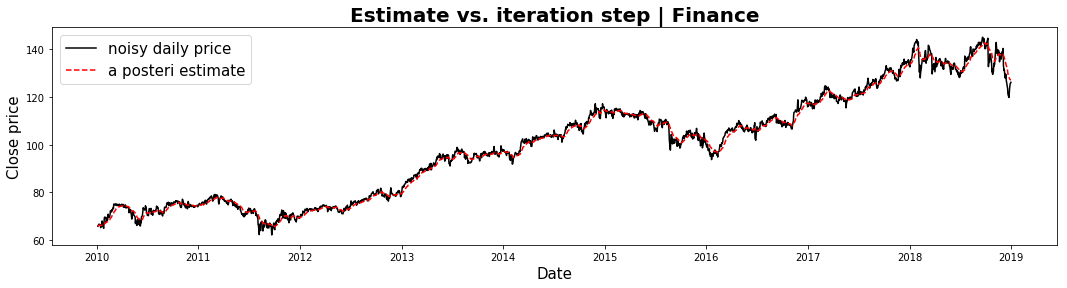

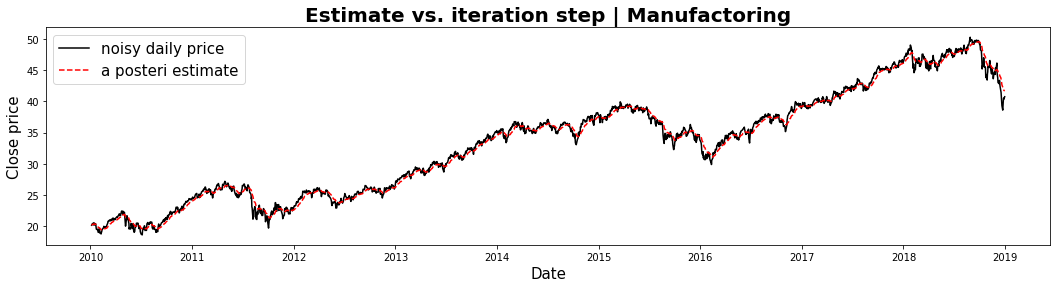

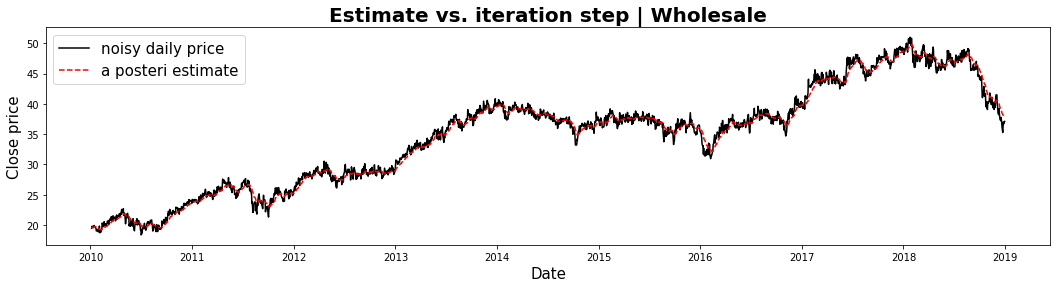

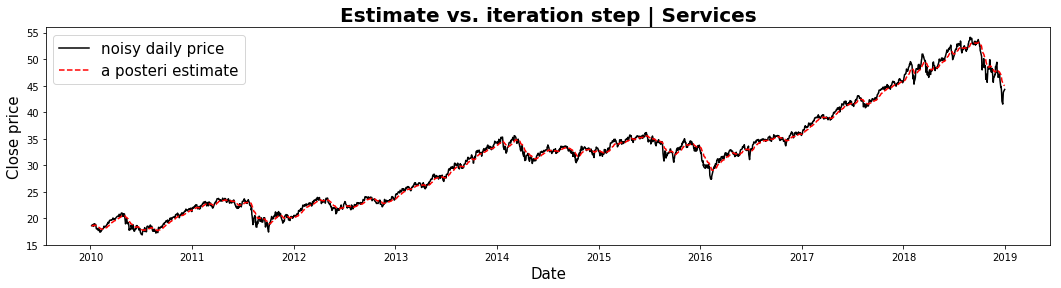

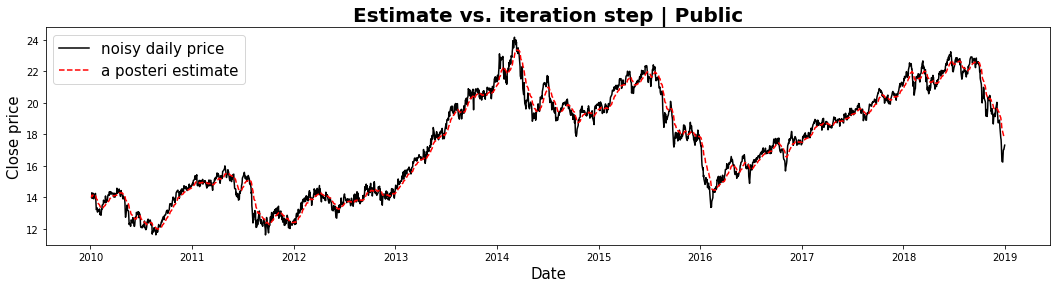

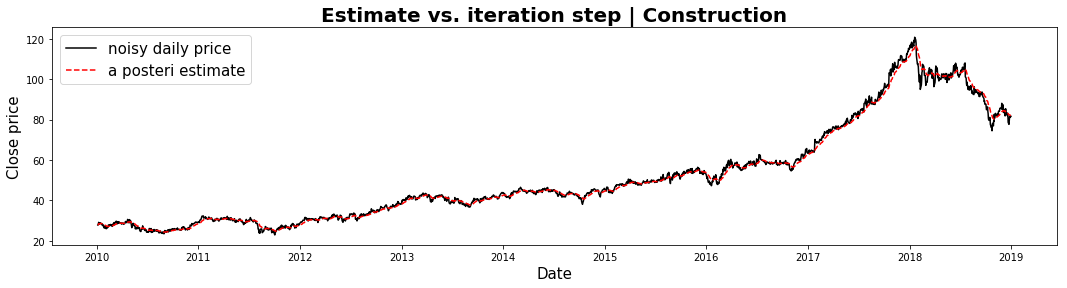

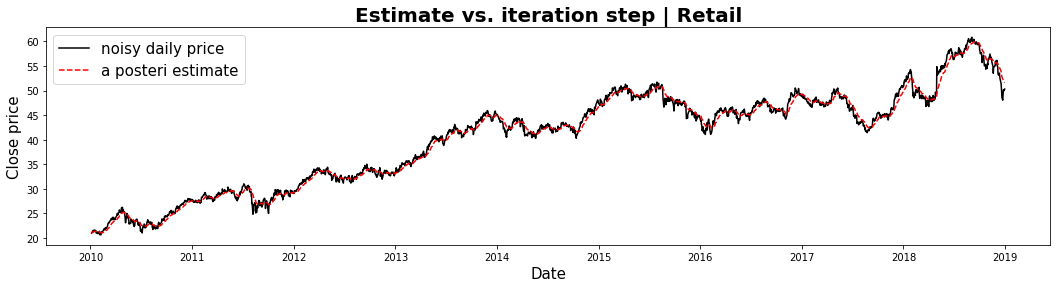

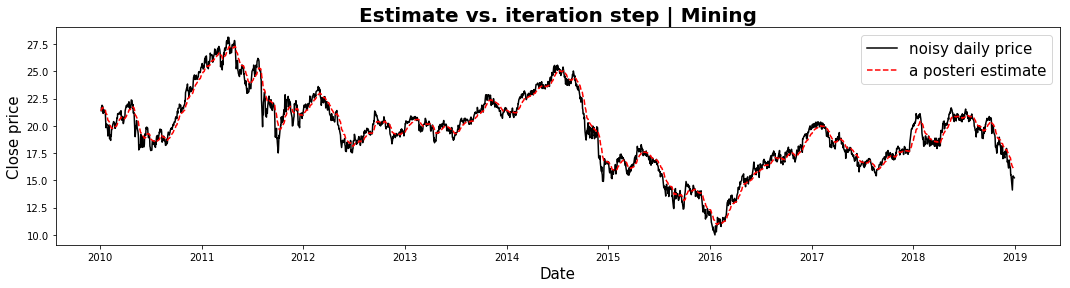

In [4]:
data = []
for ind in ind_list:
    data_ind = pd.read_csv('data/'+ind+'.csv',index_col=0,low_memory=False)
    data_ind.index=pd.to_datetime(data_ind.index)
    data_ind['smooth_close']=kalman_filter(data_ind,title=ind)
    data_ind = data_ind[['close','smooth_close']]
    data_ind.columns=['close_'+ind,'smooth_'+ind]
    data.append(data_ind)
#     df.drop(pd.datetime(2010,1,4)).to_csv('smooth_'+ind+'.csv')

Text(0.5, 1.0, 'Close Price of 9 Industries Index')

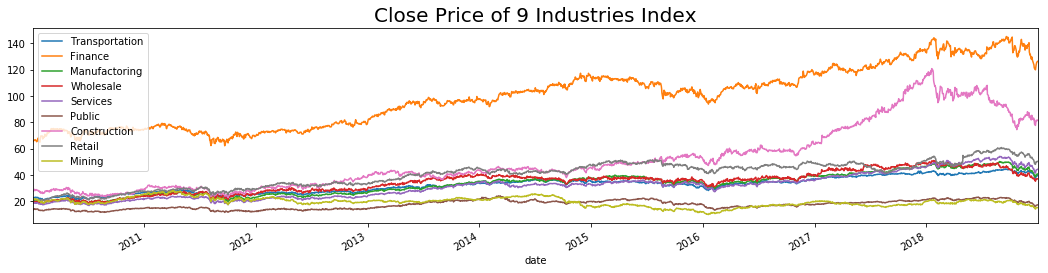

In [55]:
a=data_all[['close_'+ind for ind in ind_list]]
a.columns=ind_list
a.plot()
plt.title('Close Price of 9 Industries Index',fontsize=20)

In [5]:
data_all = pd.concat(data,axis=1,sort=False)

In [8]:
data_all.drop(pd.datetime(2010,1,4)).head()#to_csv('smooth_industry.csv')

,close_Transportation,smooth_Transportation,close_Finance,smooth_Finance,close_Manufactoring,smooth_Manufactoring,close_Wholesale,smooth_Wholesale,close_Services,smooth_Services,close_Public,smooth_Public,close_Construction,smooth_Construction,close_Retail,smooth_Retail,close_Mining,smooth_Mining
date,,,,,,,,,,,,,,,,,,
2010-01-05,22.823604,22.800803,65.830455,65.764691,20.195778,20.175603,19.462535,19.443092,18.636101,18.617484,14.008396,13.994401,27.807690,27.779911,21.030696,21.009687,21.387686,21.366320
2010-01-06,22.877452,22.839299,66.142888,65.954637,20.277470,20.226764,19.574467,19.509074,18.604432,18.610929,14.292948,14.144343,27.964614,27.872676,21.118698,21.064437,21.711506,21.539686
2010-01-07,22.882703,22.854001,66.229848,66.047859,20.362396,20.272707,19.811392,19.611478,18.591263,18.604267,13.936618,14.073981,28.629108,28.128902,21.232373,21.121322,21.642212,21.574415
2010-01-08,22.921272,22.871395,66.612488,66.193850,20.446907,20.317748,19.611474,19.611477,18.840240,18.665281,14.219720,14.111663,29.115584,28.384020,21.331934,21.175778,21.888843,21.655714
2010-01-11,23.016817,22.902181,66.669747,66.294600,20.511654,20.358799,19.685278,19.627101,18.733277,18.679676,14.257421,14.142521,28.236922,28.352878,21.561473,21.257431,21.744483,21.674507


## Other attempts: model up and down

In [65]:
df['ret_up']=1 
df['ret_up'].loc[df['ret']<0]=0
# df['ret_up'].loc[abs(df['ret']-0)<1e-4]=0

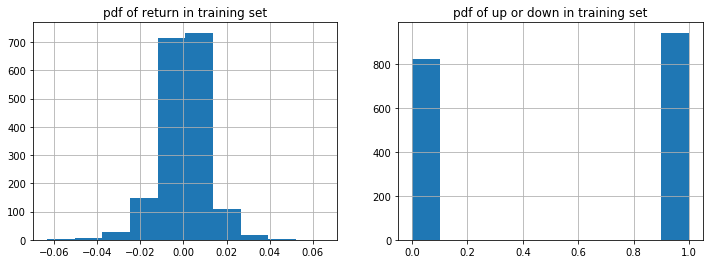

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['ret'][df.index<test_date])
plt.title('pdf of return in training set')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df['ret_up'][df.index<test_date])
plt.grid()
plt.title('pdf of up or down in training set')
plt.show()

### Bernoulli distribution

\begin{align}
\left\{
 \begin{array}{ll}
     \theta_t = \theta_{t-1}+\epsilon_t & \epsilon_t \sim N(0,\sigma^2_\epsilon)\\
     \log\frac{\pi_t}{1-\pi_t} = \theta_t \\
     y_t |\pi_t \sim Bernoulli(\pi_t)   
 \end{array}
\right.
\end{align}

Therefore, we derive the following equations:
\begin{align}
\left\{
 \begin{array}{l}
     \theta_{t|t-1} = \theta_{t-1|t-1} \\
     \sigma^2_{t|t-1} = \sigma^2_{t-1|t-1}+\sigma^2_\epsilon\\
      \theta_{t|t} = \theta_{t|t-1} + \sigma^2_{t|t-1}(y_t-\pi_t)\\
     \sigma^2_{t|t} = (\pi_t(1-\pi_t)+\frac{1}{\sigma^2_{t|t-1}})^{-1}\\
 \end{array}
\right.
\end{align}

### Poisson distribution

\begin{align}
\left\{
 \begin{array}{ll}
     \theta_t = \theta_{t-1}+\epsilon_t & \epsilon_t \sim N(0,\sigma^2_\epsilon)\\
     \log\lambda_t = \theta_t \\
     y_t |\lambda_t \sim Poisson(\lambda_t)   
 \end{array}
\right.
\end{align}

Therefore, the poisson filter is as follows:
\begin{align}
\left\{
 \begin{array}{l}
     \theta_{t|t-1} = \theta_{t-1|t-1} \\
     \sigma^2_{t|t-1} = \sigma^2_{t-1|t-1}+\sigma^2_\epsilon\\
      \theta_{t|t} = \theta_{t|t-1} + \sigma^2_{t|t}(y_t-e^{\theta_{t|t-1}})\\
     \sigma^2_{t|t} = (e^{\theta_{t|t-1}}+\frac{1}{\sigma^2_{t|t-1}})^{-1}\\
     f(y_{t}|\theta_t)=(\theta_{t|t})^{y_t}e^{-\theta_{t|t}}
 \end{array}
\right.
\end{align}

### Binormial distribution

In [36]:
def cal_pt_filter(sigma,Y,theta0=-3.5,sigma0=0,T=50):
    theta_t=theta0
    sigma_t=sigma0
    p_t=[]
    for i in range(len(Y)):
        sigma_t_1=sigma_t+sigma
        p_t_1=np.exp(theta_t)/(1+np.exp(theta_t))
        sigma_t=1/(1/sigma_t_1+T*p_t_1*(1-p_t_1))
        theta_t=theta_t+sigma_t*(Y[i]-T*p_t_1)
        p_t.append(np.exp(theta_t)/(1+np.exp(theta_t)))
    return p_t

In [41]:
ret_pred=cal_pt_filter(sigma=0.001,Y=df['ret'],T=1)

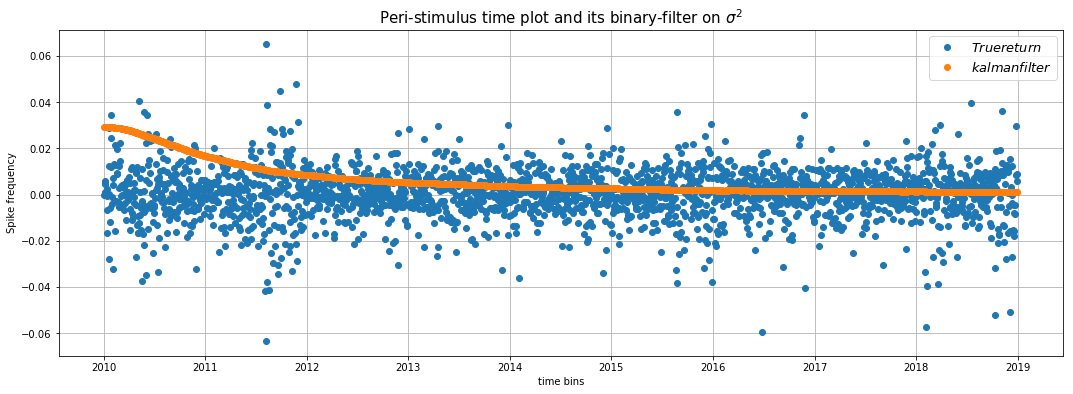

In [42]:
plt.figure(figsize=(18,6))
plt.plot_date(df.index,df['ret'],label='$True return$')
plt.plot_date(df.index,ret_pred,label='$kalman filter$')
plt.ylabel('Spike frequency')
plt.xlabel('time bins')
plt.title('Peri-stimulus time plot and its binary-filter on $\sigma^2$',fontsize=15)
plt.legend(fontsize=13)
plt.grid()

In [ ]:
y_pred